In [38]:
# xây dựng data D
import numpy as np
import pandas as pd
import random

# Bước 1: Thiết lập số lượng mẫu dữ liệu
n_samples = 500

# Bước 2: Tạo dữ liệu giả lập cho các bình luận sản phẩm
products = ['Điện thoại', 'Laptop', 'Giày thể thao', 'Áo thun', 'Bàn phím cơ']
comments = [
    'Sản phẩm rất tốt, giao hàng nhanh.',
    'Chất lượng không đúng như mong đợi.',
    'Đóng gói cẩn thận, giá hợp lý.',
    'Màu sắc đẹp, nhưng chất liệu không ổn.',
    'Dịch vụ khách hàng rất tệ.',
    'Hàng giao thiếu phụ kiện, nhưng shop đã xử lý nhanh.',
    'Sẽ tiếp tục mua hàng lần sau.',
    'Sản phẩm bị lỗi, yêu cầu đổi trả.',
    'Giao hàng rất nhanh và đúng hẹn.',
    'Không hài lòng với chất lượng sản phẩm.'
]
users = [f'user_{i}' for i in range(1, n_samples + 1)]

# Bước 3: Tạo các cột dữ liệu
data = {
    'Product': np.random.choice(products, n_samples),          # Tên sản phẩm
    'User': np.random.choice(users, n_samples),                # Người bình luận
    'Comment': np.random.choice(comments, n_samples),          # Nội dung bình luận
    'Rating': np.random.randint(1, 6, n_samples),              # Số sao đánh giá (1-5)
    'Date': pd.to_datetime(np.random.choice(pd.date_range('2023-01-01', '2024-10-29'), n_samples))  # Ngày đánh giá
}

# Bước 4: Tạo DataFrame và lưu vào file CSV
df = pd.DataFrame(data)
df.to_csv('shopee_comments.csv', index=False)

# Hiển thị 5 dòng đầu tiên của bộ dữ liệu
print(df.head())

print("Dữ liệu đã được lưu vào file 'shopee_comments.csv'")


         Product      User                                  Comment  Rating  \
0        Áo thun  user_268       Sản phẩm rất tốt, giao hàng nhanh.       2   
1  Giày thể thao  user_398               Dịch vụ khách hàng rất tệ.       4   
2        Áo thun  user_319            Sẽ tiếp tục mua hàng lần sau.       4   
3     Điện thoại  user_295  Không hài lòng với chất lượng sản phẩm.       5   
4    Bàn phím cơ  user_141           Đóng gói cẩn thận, giá hợp lý.       4   

        Date  
0 2023-04-04  
1 2023-09-03  
2 2023-02-08  
3 2024-10-11  
4 2023-06-03  
Dữ liệu đã được lưu vào file 'shopee_comments.csv'


In [39]:
# Sử dụng CNN để Phân tích Bình luận
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Bước 1: Đọc dữ liệu từ file CSV
df = pd.read_csv('shopee_comments.csv')

# Bước 2: Chuẩn bị dữ liệu
# Mã hóa nhãn số sao (1 đến 5)
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])  # Mã hóa nhãn thành số

# Chia dữ liệu thành đặc trưng (X) và nhãn (y)
X = df['Comment'].values
y = pd.get_dummies(df['Rating']).values  # Chuyển nhãn thành one-hot encoding

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 3: Tiền xử lý văn bản bằng Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Sử dụng 5000 từ phổ biến nhất
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)  # Chuyển văn bản thành chuỗi số
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Đệm (padding) các chuỗi để đảm bảo cùng độ dài
max_len = 100  # Độ dài tối đa mỗi chuỗi
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Bước 4: Xây dựng mô hình CNN
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),  # Embedding layer
    Conv1D(128, 5, activation='relu'),  # Convolution layer
    GlobalMaxPooling1D(),  # Pooling layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(5, activation='softmax')  # Output layer cho 5 lớp (số sao)
])

# Bước 5: Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Bước 6: Huấn luyện mô hình
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Bước 7: Đánh giá mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Bước 8: Dự đoán với bình luận mới
new_comment = ["Sản phẩm rất tuyệt vời và giao hàng nhanh chóng."]
new_comment_seq = tokenizer.texts_to_sequences(new_comment)
new_comment_pad = pad_sequences(new_comment_seq, maxlen=max_len, padding='post')

pred = model.predict(new_comment_pad)
pred_rating = np.argmax(pred) + 1  # Chuyển nhãn dự đoán thành số sao
print(f'Dự đoán số sao: {pred_rating}')


Epoch 1/5


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.2075 - loss: 1.6118 - val_accuracy: 0.2400 - val_loss: 1.6166
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2753 - loss: 1.5883 - val_accuracy: 0.1700 - val_loss: 1.6249
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3140 - loss: 1.5783 - val_accuracy: 0.1500 - val_loss: 1.6317
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2424 - loss: 1.5697 - val_accuracy: 0.1400 - val_loss: 1.6366
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2779 - loss: 1.5772 - val_accuracy: 0.1300 - val_loss: 1.6447
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1155 - loss: 1.6398
Loss: 1.6447, Accuracy: 0.1300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Dự đoán số sao: 3


In [40]:
# RNN 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Bước 1: Đọc dữ liệu từ file CSV
df = pd.read_csv('shopee_comments.csv')

# Bước 2: Chuẩn bị dữ liệu
# Mã hóa nhãn số sao (1 đến 5)
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])  # Mã hóa nhãn thành số

# Chia dữ liệu thành đặc trưng (X) và nhãn (y)
X = df['Comment'].values
y = pd.get_dummies(df['Rating']).values  # Chuyển nhãn thành one-hot encoding

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 3: Tiền xử lý văn bản bằng Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Sử dụng 5000 từ phổ biến nhất
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)  # Chuyển văn bản thành chuỗi số
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Đệm (padding) các chuỗi để đảm bảo cùng độ dài
max_len = 100  # Độ dài tối đa mỗi chuỗi
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Bước 4: Xây dựng mô hình RNN
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),  # Embedding layer
    SimpleRNN(128, activation='tanh', return_sequences=False),  # RNN Layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(5, activation='softmax')  # Output layer cho 5 lớp (số sao)
])

# Bước 5: Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Bước 6: Huấn luyện mô hình
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Bước 7: Đánh giá mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Bước 8: Dự đoán với bình luận mới
new_comment = ["Sản phẩm rất tuyệt vời và giao hàng nhanh chóng."]
new_comment_seq = tokenizer.texts_to_sequences(new_comment)
new_comment_pad = pad_sequences(new_comment_seq, maxlen=max_len, padding='post')

pred = model.predict(new_comment_pad)
pred_rating = np.argmax(pred) + 1  # Chuyển nhãn dự đoán thành số sao
print(f'Dự đoán số sao: {pred_rating}')


Epoch 1/5


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.1587 - loss: 1.6425 - val_accuracy: 0.2900 - val_loss: 1.5913
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2249 - loss: 1.6066 - val_accuracy: 0.1400 - val_loss: 1.6609
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2291 - loss: 1.6178 - val_accuracy: 0.1600 - val_loss: 1.6573
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2032 - loss: 1.6261 - val_accuracy: 0.2000 - val_loss: 1.6577
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1769 - loss: 1.6613 - val_accuracy: 0.2800 - val_loss: 1.5935
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2620 - loss: 1.5982
Loss: 1.5935, Accuracy: 0.2800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Dự đoán số sao: 2


In [41]:
# LSTM 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Bước 1: Đọc dữ liệu từ file CSV
df = pd.read_csv('shopee_comments.csv')

# Bước 2: Chuẩn bị dữ liệu
# Mã hóa nhãn số sao (1 đến 5)
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])  # Mã hóa nhãn thành số

# Chia dữ liệu thành đặc trưng (X) và nhãn (y)
X = df['Comment'].values
y = pd.get_dummies(df['Rating']).values  # Chuyển nhãn thành one-hot encoding

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 3: Tiền xử lý văn bản bằng Tokenizer
tokenizer = Tokenizer(num_words=5000)  # Sử dụng 5000 từ phổ biến nhất
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)  # Chuyển văn bản thành chuỗi số
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Đệm (padding) các chuỗi để đảm bảo cùng độ dài
max_len = 100  # Độ dài tối đa mỗi chuỗi
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Bước 4: Xây dựng mô hình LSTM
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),  # Embedding layer
    LSTM(128, activation='tanh', return_sequences=False),  # LSTM Layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(5, activation='softmax')  # Output layer cho 5 lớp (số sao)
])

# Bước 5: Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Bước 6: Huấn luyện mô hình
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Bước 7: Đánh giá mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Bước 8: Dự đoán với bình luận mới
new_comment = ["Sản phẩm rất tuyệt vời và giao hàng nhanh chóng."]
new_comment_seq = tokenizer.texts_to_sequences(new_comment)
new_comment_pad = pad_sequences(new_comment_seq, maxlen=max_len, padding='post')

pred = model.predict(new_comment_pad)
pred_rating = np.argmax(pred) + 1  # Chuyển nhãn dự đoán thành số sao
print(f'Dự đoán số sao: {pred_rating}')


Epoch 1/5


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.2160 - loss: 1.6132 - val_accuracy: 0.2000 - val_loss: 1.6136
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.2304 - loss: 1.6084 - val_accuracy: 0.2000 - val_loss: 1.6162
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1980 - loss: 1.6103 - val_accuracy: 0.2000 - val_loss: 1.6082
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.1794 - loss: 1.6106 - val_accuracy: 0.2800 - val_loss: 1.6088
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.2194 - loss: 1.6084 - val_accuracy: 0.2000 - val_loss: 1.6128
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2248 - loss: 1.6128
Loss: 1.6128, Accuracy: 0.2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Dự đoán số sao: 3


c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


CNN - Loss: 1.6300, Accuracy: 0.1800, MAE: 0.3200, MSE: 0.1619
RNN - Loss: 1.6326, Accuracy: 0.1500, MAE: 0.3208, MSE: 0.1620
LSTM - Loss: 1.6176, Accuracy: 0.1600, MAE: 0.3205, MSE: 0.1607


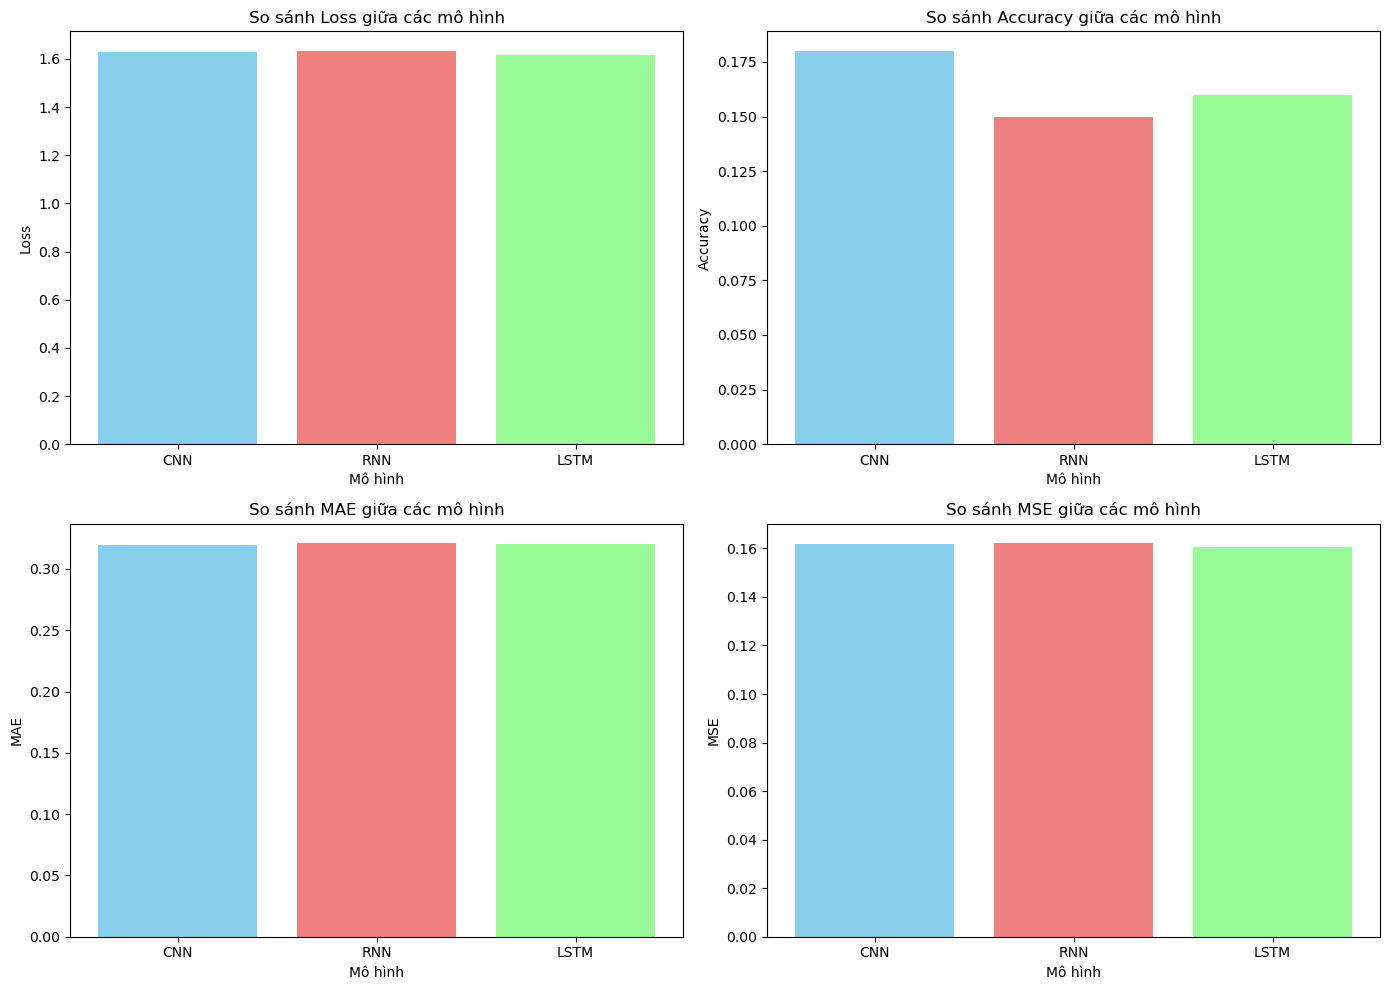

In [42]:
# So sánh mô hình
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Bước 1: Đọc dữ liệu từ file CSV
df = pd.read_csv('shopee_comments.csv')

# Bước 2: Chuẩn bị dữ liệu
label_encoder = LabelEncoder()
df['Rating'] = label_encoder.fit_transform(df['Rating'])

X = df['Comment'].values
y = pd.get_dummies(df['Rating']).values

# Bước 3: Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 4: Tokenizer và Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Hàm để huấn luyện và đánh giá mô hình
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy', 'mae', 'mse'])
    history = model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0, 
                        validation_data=(X_test, y_test))
    loss, accuracy, mae, mse = model.evaluate(X_test, y_test, verbose=0)
    print(f'{model_name} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}')
    return loss, accuracy, mae, mse

# CNN Model
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
cnn_loss, cnn_acc, cnn_mae, cnn_mse = train_and_evaluate(cnn_model, X_train_pad, y_train, X_test_pad, y_test, 'CNN')

# RNN Model
rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    SimpleRNN(128, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
rnn_loss, rnn_acc, rnn_mae, rnn_mse = train_and_evaluate(rnn_model, X_train_pad, y_train, X_test_pad, y_test, 'RNN')

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    LSTM(128, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
lstm_loss, lstm_acc, lstm_mae, lstm_mse = train_and_evaluate(lstm_model, X_train_pad, y_train, X_test_pad, y_test, 'LSTM')

# Bước 6: So sánh các kết quả bằng biểu đồ
models = ['CNN', 'RNN', 'LSTM']
loss_values = [cnn_loss, rnn_loss, lstm_loss]
accuracy_values = [cnn_acc, rnn_acc, lstm_acc]
mae_values = [cnn_mae, rnn_mae, lstm_mae]
mse_values = [cnn_mse, rnn_mse, lstm_mse]

# Vẽ biểu đồ so sánh
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Biểu đồ Loss
ax[0, 0].bar(models, loss_values, color=['skyblue', 'lightcoral', 'palegreen'])
ax[0, 0].set_title('So sánh Loss giữa các mô hình')
ax[0, 0].set_xlabel('Mô hình')
ax[0, 0].set_ylabel('Loss')

# Biểu đồ Accuracy
ax[0, 1].bar(models, accuracy_values, color=['skyblue', 'lightcoral', 'palegreen'])
ax[0, 1].set_title('So sánh Accuracy giữa các mô hình')
ax[0, 1].set_xlabel('Mô hình')
ax[0, 1].set_ylabel('Accuracy')

# Biểu đồ MAE
ax[1, 0].bar(models, mae_values, color=['skyblue', 'lightcoral', 'palegreen'])
ax[1, 0].set_title('So sánh MAE giữa các mô hình')
ax[1, 0].set_xlabel('Mô hình')
ax[1, 0].set_ylabel('MAE')

# Biểu đồ MSE
ax[1, 1].bar(models, mse_values, color=['skyblue', 'lightcoral', 'palegreen'])
ax[1, 1].set_title('So sánh MSE giữa các mô hình')
ax[1, 1].set_xlabel('Mô hình')
ax[1, 1].set_ylabel('MSE')

plt.tight_layout()
plt.show()

